In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import numpy as np
seed = 42
np.random.seed(seed)
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import scipy
import cvxopt
import autograd
import autograd.numpy as np
import domain_adapt.domain_adapt.new.fxns as fxns
import domain_adapt.domain_adapt.new.utils as utils
import domain_adapt.domain_adapt.new.optimizers as optimizers
import domain_adapt.domain_adapt.SDR_data as data

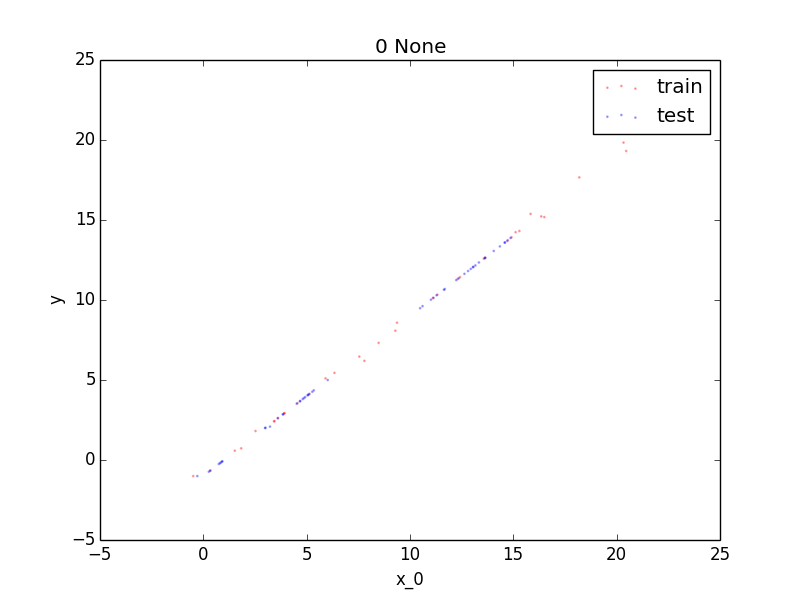

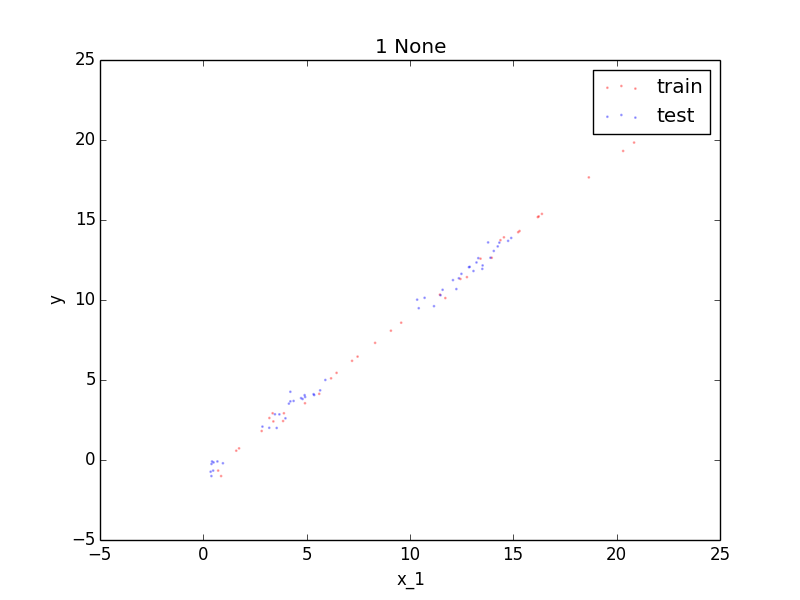

anal_grad (2, 2, 2)
[[[-0.26099354 -0.24001574]
  [-0.08038303 -0.00856997]]

 [[-0.4828292   0.08008823]
  [-0.6674561  -0.15151445]]]
numerical_grad (2, 2, 2)
[[[-0.26145834 -0.23991404]
  [-0.08072894 -0.00754486]]

 [[-0.48213158  0.07989141]
  [-0.66704057 -0.15236703]]]
error 0.00167983420856


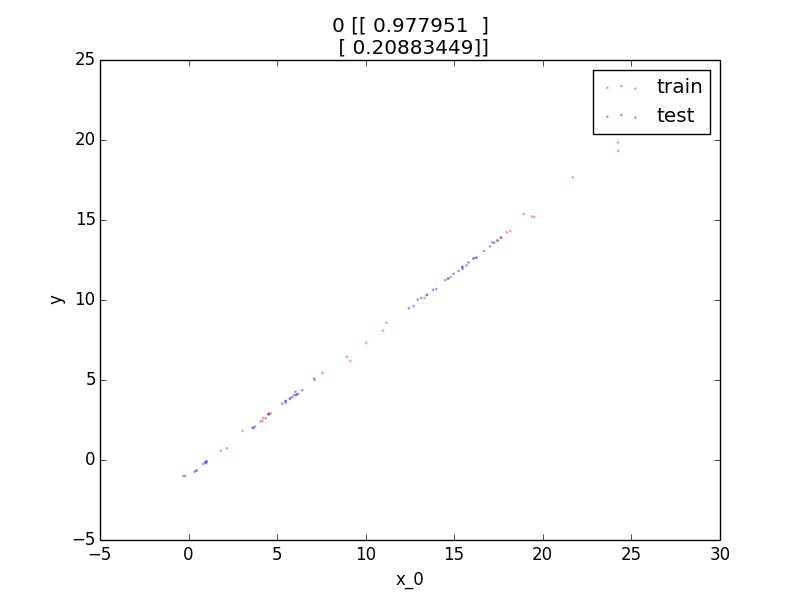

14.2178127234 test loss


In [27]:
# see if can recover 'true' subspace

np.random.seed(42)

# get data
#num_train, num_test = 100, 125
num_train, num_test = 35, 50
x_dim = 2
xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=x_dim, num_train=num_train, num_test=num_test)


# plot data
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test)
data.data.plot_ys_v_xs(1, xs_train, xs_test, ys_train, ys_test)

logreg_ratio_objective = fxns.logreg_ratio_objective.autograd_fxn(scale_sigma=False)
dlogreg_ratio_objective_db = fxns.dopt_objective_dx.autograd_fxn(logreg_ratio_objective)
damp = .1
def lstsq_solver(A,b): 
    ans = scipy.sparse.linalg.lsmr(A, b, damp=damp)
    print ans, 'end'
    return ans[0]
#lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A, b, damp=damp)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
lsmr_solver = None
lin_solver = cg_solver
b_ratio_opt_given_B_fxn = fxns.cvx_opt(# xs_train, xs_test, sigma, B, c_logreg
    lin_solver=lin_solver, 
    objective=logreg_ratio_objective, 
    dobjective_dx=dlogreg_ratio_objective_db
)

b_ratio_opt_to_b_reg_opt = fxns.two_step( # b_ratio_opt, xs_train, xs_test, ys_train, sigma, B, c_lsqr
    g=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios), # b_ratio_opt, xs_train, xs_test, sigma, B
    h=fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt), # B, xs_train, ys_train, ws_train, c_lsqr
    g_argnums=(0,1,2,4,5),
    h_argnums=(5,1,3,6),
    g_val_h_argnum=3
)

b_ratio_reg_opt_fxn = fxns.two_step( # xs_train, xs_test, ys_train, sigma, B, c_logreg, c_lsqr
    g=b_ratio_opt_given_B_fxn, # xs_train, xs_test, sigma, B, c_logreg
    h=b_ratio_opt_to_b_reg_opt, # b_ratio_opt, xs_train, xs_test, ys_train, sigma, B, c_lsqr
    g_argnums=(0,1,3,4,5),
    h_argnums=(0,1,2,3,4,6),
    g_val_h_argnum=0
)

B = np.eye(x_dim)
sigma = np.array([utils.median_distance(np.vstack((xs_train, xs_test)), np.vstack((xs_train, xs_test)))])
c_logreg, c_lsqr = 0.1, 4.1

b_ratio_reg_opt_fxn.grad_check(xs_train, xs_test, ys_train, sigma, B, c_logreg, c_lsqr, care_argnums=(4,))

b_fit = b_ratio_reg_opt_fxn.val(xs_train, xs_test, ys_train, sigma, B, c_logreg, c_lsqr)

data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, ax=None, B=utils.ortho(np.array([b_fit]).T))

print fxns.weighted_squared_loss_given_B(b_fit, xs_test, ys_test, c=0), 'test loss'

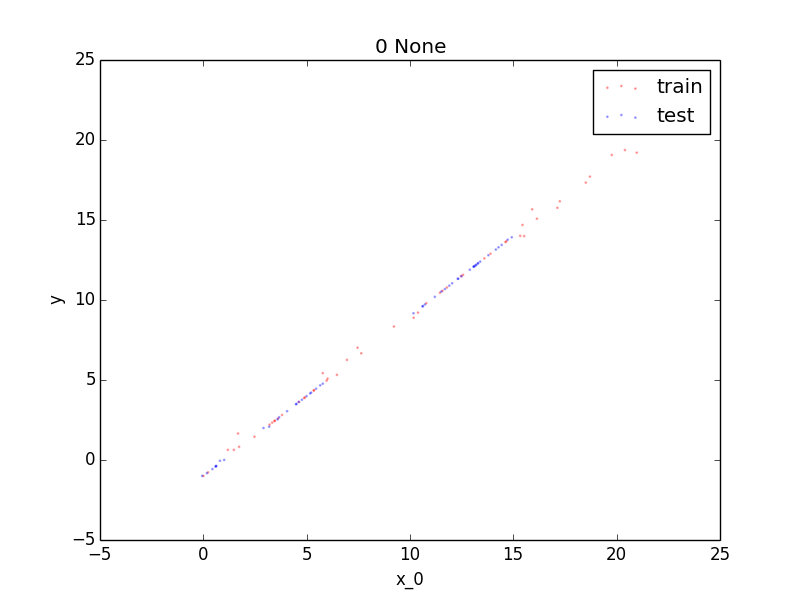

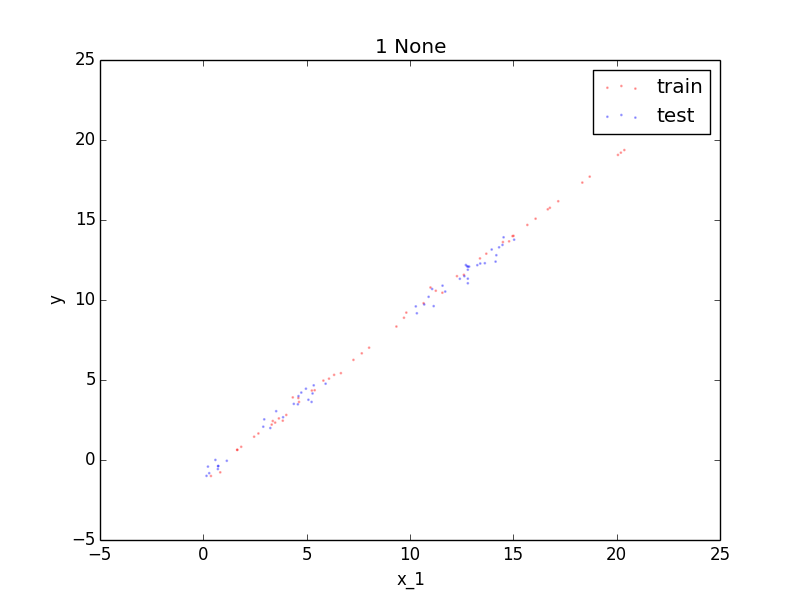

[ 10.] sigma
0.653173548745 b_fit norm


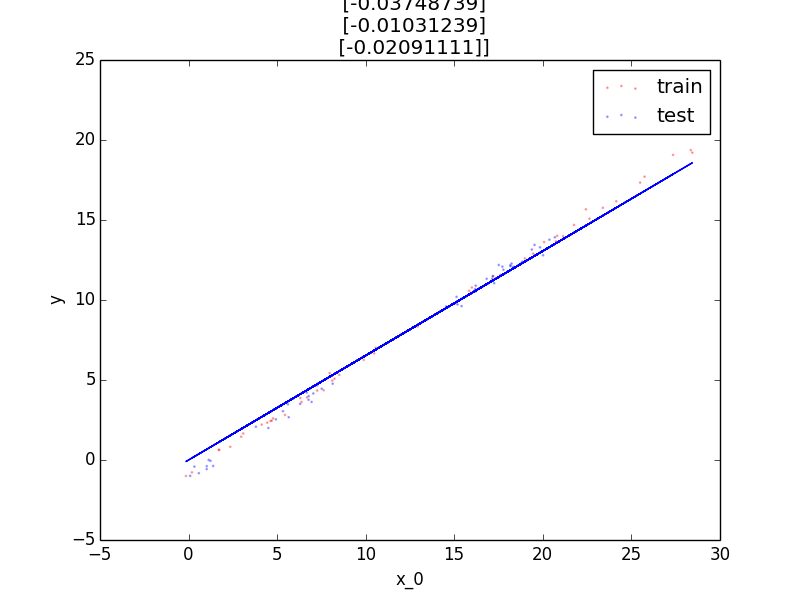

17.015970252 test loss
[ 10.] sigma2


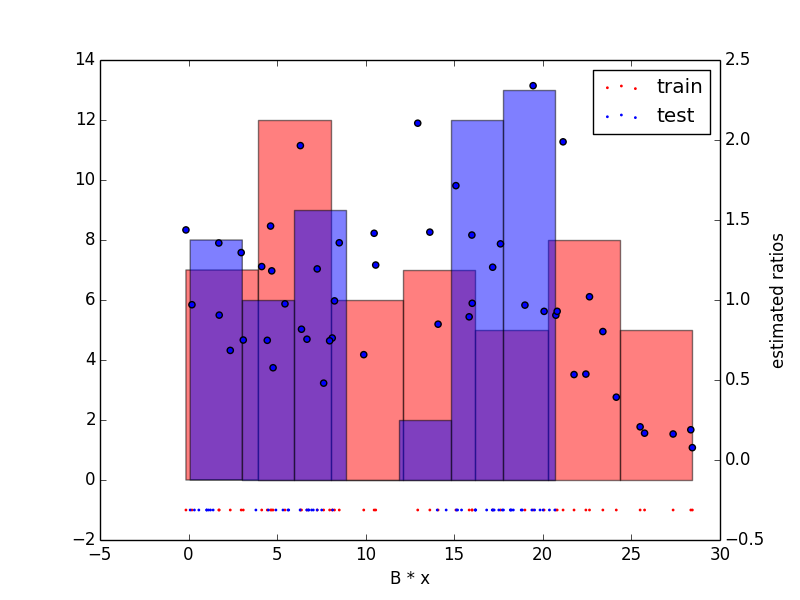

In [28]:
# apply baseline to higher dimensional data

np.random.seed(42)

# get data
#num_train, num_test = 100, 125
#num_train, num_test = 35, 50
#num_train, num_test = 125, 125
#num_train, num_test = 200, 200
num_train, num_test = 50, 50
#x_dim = 30
x_dim = 50
xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=x_dim, num_train=num_train, num_test=num_test)
#xs_train, xs_test, ys_train, ys_test = data.v_data(x_dim=x_dim, num_train=num_train, num_test=num_test)
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test)
data.data.plot_ys_v_xs(1, xs_train, xs_test, ys_train, ys_test)
#data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, B=utils.ortho(np.array([(1,1)+(0,)*(x_dim-2)]).T))
#xs_train, xs_test, ys_train, ys_test = data.v_data(x_dim=x_dim, num_train=num_train, num_test=num_test)
#assert False
#data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test)
#data.data.plot_ys_v_xs(1, xs_train, xs_test, ys_train, ys_test)
#data.data.plot_ys_v_xs(3, xs_train, xs_test, ys_train, ys_test)

B = np.eye(x_dim)
#sigma = np.array([utils.median_distance(np.vstack((xs_train, xs_test)), np.vstack((xs_train, xs_test)))]) - 5
sigma = np.array([10.])
#sigma = np.array([.25])
#sigma = np.array([1.75])
#sigma = np.array([5.25])
print sigma, 'sigma'
#c_logreg, c_lsqr = 0.1, 4.1
#c_logreg, c_lsqr = 1.1, 10.1
#c_logreg, c_lsqr = .1, .1
#c_logreg, c_lsqr = 1.1, 5.1
#c_logreg, c_lsqr = .01, 5.1
c_logreg, c_lsqr = .1, 100.


#b_ratio_reg_opt_fxn.grad_check(xs_train, xs_test, ys_train, sigma, B, care_argnums=(4,))

b_fit = b_ratio_reg_opt_fxn.val(xs_train, xs_test, ys_train, sigma, B, c_logreg, c_lsqr)

#print b_fit
print np.linalg.norm(b_fit), 'b_fit norm'
fig,ax = plt.subplots()
data.data.plot_ys_v_xs(0, xs_train, xs_test, ys_train, ys_test, ax=ax, B=utils.ortho(np.array([b_fit]).T))
ax.plot(np.dot(xs_train,b_fit)/np.linalg.norm(b_fit), np.dot(xs_train,b_fit))
basic.display_fig_inline(fig)

print fxns.weighted_squared_loss_given_B(b_fit, xs_test, ys_test, c=0.), 'test loss'

ratio_fxn = fxns.two_step( # xs_train, xs_test, sigma, B, c_logreg
    g=b_ratio_opt_given_B_fxn, # xs_train, xs_test, sigma, B, c_logreg
    h=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios), # b_ratio_opt, xs_train, xs_test, sigma, B
    g_argnums=(0,1,2,3,4),
    h_argnums=(0,1,2,3),
    g_val_h_argnum=0
)
print sigma, 'sigma2'
ratios = ratio_fxn.val(xs_train, xs_test, sigma, B, c_logreg)

fig, ax = plt.subplots()
real_B_fit = utils.ortho(np.array([b_fit]).T)
data.data.plot_us(real_B_fit, xs_train, xs_test, ax)
ratio_ax = ax.twinx()
ratio_ax.scatter(np.dot(xs_train,real_B_fit), ratios)
ratio_ax.set_ylabel('estimated ratios')
basic.display_fig_inline(fig)

# define predictor

In [26]:
b_fit

array([ 0.46260755,  0.44048284, -0.00584408,  0.03607337, -0.00778411,
        0.0072112 , -0.01918993,  0.0111997 , -0.00133727, -0.00067576,
        0.02405937, -0.01779543,  0.0074412 , -0.0206852 ,  0.00114059,
       -0.04171004, -0.04267846,  0.01357623, -0.0123211 , -0.02453559,
        0.01041722, -0.0200488 , -0.00578738, -0.01071011,  0.03114788,
        0.02534544, -0.04154557, -0.01443952, -0.00280057, -0.00874764,
        0.01991655, -0.02081326, -0.01099941, -0.01093399, -0.0028547 ,
        0.01013215,  0.02126778, -0.02776895,  0.02954575, -0.03792853,
        0.00239734, -0.00824097,  0.02282533, -0.00093583, -0.00726616,
        0.01599203, -0.00629143, -0.02448577, -0.00673578, -0.01365858])